# Import

In [41]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# utils

In [26]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Train Image 읽어오기
- pixel의 크기는 몇인지 알아보자.
- 데이터의 개수는 몇 개인지 알아보자.

In [14]:
import os
import numpy as np
from PIL import Image

folder_path = "../open (1)/train_img"
image_files = os.listdir(folder_path)
train_images = []

for file_name in image_files:
    file_path = os.path.join(folder_path, file_name)

    image = Image.open(file_path)
    rgb_vector = np.array(image)
    train_images.append(rgb_vector)
train_images = np.array(train_images)
print(train_images.shape) # (7140, 1024, 1024, 3)

(7140, 1024, 1024, 3)


- 모든 images는 1024 * 1024 * 3 크기이다. train data는 7140개이다.
    - baseline에서는 train, test image를 224 * 224 resizing 했는데, 너무 압축되지 않나? 하는 생각이 든다.
    - 7140개면 조금 적은 편인 것 같다. 데이터 증강 기법을 사용하는 편이 좋겠다.

# label의 편향 확인
- train data에는 모두 건물(1)이 존재한다. 그럼 각 data는 1024 * 1024개의 pixel 중 몇 개의 1을 가지고 있을까?
- train data는 mast_rle 형식으로 label이 적혀 있다. 따라서 1의 개수만을 모두 더해서 그 비율을 파악해보자.

In [27]:
# csv load
csv_file = "../open (1)/train.csv"
train_data = pd.read_csv(csv_file)

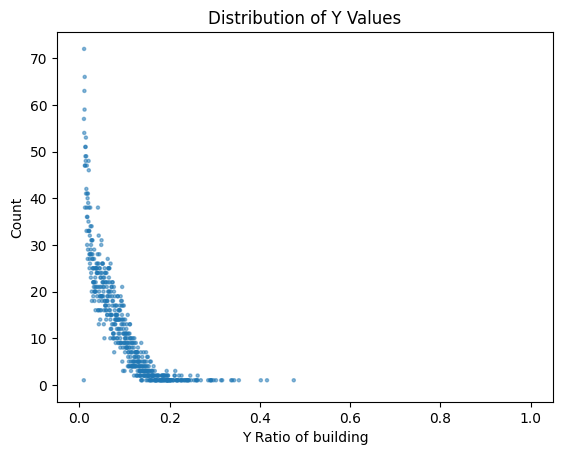

min ratio:  0.010000228881835938
max ratio:  0.47540950775146484


In [62]:
# 주어진 데이터
x1 = len(train_data)
y1 = train_data['mask_rle'].apply(lambda x: np.sum(list(map(int, x.split()[1:][::2])))/(1024*1024)).values

# 그래프의 x축 범위
x_range = np.linspace(0, 1, num = 3000)

# x축 각 구간에 속하는 데이터 개수 계산
hist, bin_edges = np.histogram(y1, bins=x_range)

# 점의 크기 및 투명도 설정
marker_sizes = np.where(hist > 0, 5, 0)
alpha = 0.5

# 그래프 그리기
plt.scatter(x_range[:-1], hist, marker='o', s=marker_sizes, alpha=alpha)
plt.xlabel('Y Ratio of building')
plt.ylabel('Count')
plt.title('Distribution of Y Values')
plt.show()
print("min ratio: ", min(y1))
print("max ratio: ", max(y1))


- 분포는 위와 같다. 1024 * 1024의 pixel에서 실제로 건물이 있는 경우에 대한 그래프이다.
    - 대체로 0.2 미만 즉, 사진 속 건물의 비율은 20% 미만으로 존재한다.
    - 가장 작은 비율은  0.01 즉, 1% 정도가 건물인 경우이다.
    - 가장 큰 비율은 0.475 즉, 48% 정도가 건물인 경우이다.
- 애초에 건물이 사진에서 차지하는 비율이 대체로 낮다.
- test data에는 실제로 건물이 존재하지 않는 경우도 있다는 것을 유념하자.

# Domain Knowledge
### Rotation
- 위성 사진을 찍은 방향에 대한 정보는 없으며, 빌딩의 구획 역시 동서남북 방향에 구애받지 않는다. rotation이 가능할 것으로 판단된다.
    - 따라서 약간의 회전은 현실적인 변형으로 간주된다. 의료 영상과 같이 특정한 방향성이나 정렬이 필요한 경우엔 회전은 맞지 않다.
    - 회전을 통해 pixel의 순서를 바꾼다면 rle encoding 값 역시도 변경된다. 따라서 label도 동일하게 회전시켜 제대로 매칭해야 한다.
        - 이처럼 Object Detection, Object Segmentation에서는 회전으로 인한 위치 불일치 문제가 발생할 수 있으므로 주의한다.
        - 그렇다면 확실히 데이터 증강의 효과가 날 것 같다. 
        - 우리의 task는 a 이미지의 label이 1일 때 이를 회전시킨 a'의 label도 1인 classification 문제와는 다르다. 정답 label 자체가 달라진다.
### Flip
- rotation과 동일한 근거로 flip도 가능하다고 생각한다. 상하좌우 대칭성이 중요한 데이터는 아니다.
    - 얼굴 인식과 같이 대칭성이 중요한 작업에서는 좌우 반전을 적용하는 것이 적절하지 않을 수 있다.
    - 역시 label도 뒤집어 줘야 한다.
### Color Adjustment
- 건물이 있다고 labeling 되어 있는 곳의 RGB 값이 다른 곳과 확연한 차이를 보이는지는 수치로 확인해봐야 할 문제이다.
- 일단 직관적으로 보자면 데이터 대부분에 녹지가 껴 있고, 지붕의 색은 이러한 배경과는 다르다.
    - 녹색 계열 색과 그 이외의 색 구분이 어렵게 하는 식의 변형은 옳지 않아 보인다.
### Scaling, Cropping
- 건물의 크기가 작은 경우가 대부분이다. 1024 * 1024개의 pixel 중 1이 차지하는 비율이 20% 미만인 경우가 대부분이므로 상세한 학습이 중요하다고 판단된다.
    - 웬만하면 작게 scaling 하지 않는 것이 좋아 보인다. 차라리 이미지를 잘라서 넣는 방식이면 어떨까? 그럼 1이 차지하는 비율도 20% 미만에 편향되지 않고, 0 - 1 다양한 값을 가질 거다. 
### 모양에 대한 인사이트
- 지붕의 모양은 대체로 사각형과 삼각형이다. 전형적인 지붕의 모양이 파악 가능하겠다.
- 그림자 효과로 인해 피라미드 형태로 보이는 것이 더러 있다. 이것은 지붕의 패턴이 될 수 있겠다.
- 건물이 아니라 주차장, 공터, 호수 같은 녹색 계열이 아닌 넓은 장소가 존재한다. 이를 적절히 처리하는 방법을 떠올려야겠다.
    - 다만 코스트코 같은 대규모 건물인 경우도 존재한다. 둘의 밸런싱이 중요할 듯하다. 
### Brightness Adjustment
- 밝기 조정도 의미가 있을 것 같다. 피라미드 형태로 한 쪽 면이 그림자 진 건물이 많은데, 밝기 조정으로도 그 패턴은 유지되면서 여러 데이터를 만들 수 있을 것으로 판단된다.